# Notebook for Evan - Generating Satellite Releases
Code Author: Sahar El Abbadi
Date: 2023-04-04


In [1]:
# Setup

# imports
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import pathlib
import numpy as np
from datetime import datetime
from datetime import timedelta
from methods_source import calc_average_release
from methods_source import summarize_wind_conditions, calc_avg_windspeed
import windrose
from windrose import WindroseAxes
import plotly.express as px
import matplotlib.cm as cm
from scipy.stats import circmean, circstd

## Satellite release dataframe
Create satellite release summary file with timestamps as datetime objects in UTC. The start and stop times of the relases will be used as inputs to the calc_average_releases function.

Dummy dataset includes one example time period when we have no release record (e.g. satellite release occurred on a weekend, and there is no meter file for the date in question), and one release where we have a metered data file for the time period in question.

Import satellite data

In [2]:
# overpass_filename = pathlib.PurePath('04_figures', 'parity_plots', fig_name)
# pathlib.PurePath('01_clean_reports', 'Satellite overpass datetime 20230404.xlsx')

satellite_overpass_times = pd.read_excel(pathlib.PurePath('00_raw_reports', 'Satellite_results_consolidated_20230505d.xlsx'), )
# satellite_overpass_times = pd.read_excel(pathlib.PurePath('01_clean_reports', 'Satellite_results_consolidated_20230404b.xlsx'), )
satellite_overpass_times['end_release'] = pd.to_datetime(satellite_overpass_times['DateTime (UTC)'])
satellite_overpass_times['start_release'] = satellite_overpass_times['end_release'] - timedelta(minutes=5)
satellite_overpass_times
# satellite_timestamps = satellite_overpass_times
# satellite_timestamps

,Team,Satellite,PerformerExperimentID,FacilityID,EquipmentUnitID,DateOfSurvey,Timestamp (hyperspectral technologies only),StartTime,EndTime,SurveyTime,...,WindDirection,NumberOfEmissionSourcesReported,Notes,Data source,QC,QC_lax,UnblindingStage,DateTime (UTC),end_release,start_release
0,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-10-18 17:49:00,17:49:00,NaN,NaN,NaN,...,Excluded,NaN,Release cancelled by Stanford due to system ma...,NaN,SEA,OK,1,2022-10-18 17:49:00,2022-10-18 17:49:00,2022-10-18 17:44:00
1,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-10-26 18:14:00,2022-10-26 18:14:00,NaN,NaN,NaN,...,NaN,NaN,NaN,DataReportingTemplate_AerialAppendix_GHGSat_S2...,OK,OK,1,2022-10-26 18:14:00,2022-10-26 18:14:00,2022-10-26 18:09:00
2,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 - 10/26/2022,1,1.0,2022-11-05 18:14:00,18:14:40,NaN,NaN,NaN,...,Excluded,NaN,Release cancelled by Stanford due to personnel...,NaN,SEA,SE,1,2022-11-05 18:14:00,2022-11-05 18:14:00,2022-11-05 18:09:00
3,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 ‚Äì 11/08...,1,1.0,2022-11-08 18:24:00,2022-11-08 18:24:00,NaN,NaN,NaN,...,NaN,NaN,NaN,DataReportingTemplate_AerialAppendix_GHGSat_S2...,OK,OK,1,2022-11-08 18:24:00,2022-11-08 18:24:00,2022-11-08 18:19:00
4,GHGSat,Sentinel-2,94e765d9-f8fd-49b0-9851-57cbd7dcb4b6 ‚Äì 11/15...,1,1.0,2022-11-15 18:14:00,2022-11-15 18:14:00,NaN,NaN,NaN,...,NaN,NaN,NaN,DataReportingTemplate_AerialAppendix_GHGSat_S2...,OK,OK,1,2022-11-15 18:14:00,2022-11-15 18:14:00,2022-11-15 18:09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,Orbio,Sentinel-2,2,1,1.0,2022-11-08 00:00:00,18:25:05,NaN,NaN,NaN,...,300,NaN,NaN,2022_OrbioEarth_satellite_report_with_wind.xlsx,OK,OK,2,2022-11-08 18:25:00,2022-11-08 18:25:00,2022-11-08 18:20:00
412,Orbio,Sentinel-2,3,1,1.0,2022-11-15 00:00:00,18:15:08,NaN,NaN,NaN,...,185,NaN,NaN,2022_OrbioEarth_satellite_report_with_wind.xlsx,OK,OK,2,2022-11-15 18:15:00,2022-11-15 18:15:00,2022-11-15 18:10:00
413,Orbio,Sentinel-2,4,1,1.0,2022-11-18 00:00:00,18:25:03,NaN,NaN,NaN,...,316,NaN,NaN,2022_OrbioEarth_satellite_report_with_wind.xlsx,OK,OK,2,2022-11-18 18:25:00,2022-11-18 18:25:00,2022-11-18 18:20:00
414,Orbio,Sentinel-2,5,1,1.0,2022-11-25 00:00:00,18:15:05,NaN,NaN,NaN,...,213,NaN,NaN,2022_OrbioEarth_satellite_report_with_wind.xlsx,OK,OK,2,2022-11-25 18:15:00,2022-11-25 18:15:00,2022-11-25 18:10:00


## Calculate the gas flow rate during release periods

Use calc_average_releases function to generate gas flow profile for each time period of interest. Here, I apply the function to each row in the satellite_releases dataframe, although other methods may be used as well.

Function inputs:
- start_t: datetime object in UTC
- stop_t: datetime object in UTC

Notes:
- Function will return an error message if start_t and stop_t are on different dates (ie you cannot calculate the average flow rate if they straddle different days of testing)
- Function will return an error message if start_t is chronologically after stop_t
- If start_t and end_t occur on a date for which we do not have metered data, function will output values for a zero release (flow rate of 0 kgh, uncertainty of 0, meter and gas composition of np.nan)

Function outputs a Python dictionary with the following keys:
- gas_kgh_mean: mean gas flow rate over the time period of interest, as whole gas
- gas_kgh_sigma: standard deviation of the meter reading over the period of interest, as whole gas. This value represents the physical variability in the flow rate.
- meter_sigma: the standard deviation calculated based on the uncertainty in the meter reading for the flow rate during the period in question. Emerson reports uncertainty as a percentage of flow rate, and the function converts this value to a sigma value with units of kgh whole gas
- ch4_fraction_{gas_comp_source}: the fraction methane based on the input source for gas composition. Gas composition can be 'su_normalized', 'su_raw', or 'km'. See other documentation for additional details. This value is averaged over the time period of interest, although unless the trailer was changed mid-release, value is expected to be constant
- ch4_fraction{gas_comp_source}_sigma: the sigma value associated with the gas composition, representative of the uncertainty associated with measurements of methane mole fraction.
- ch4_kgh_mean: mean methane flow rate, calculated from the gas flow rate and methane mole fraction
- cg4_kgh_sigma: total uncertainty in the methane flow rate. This value combines physical variability in gas flow rate (gas_kgh_sigma) with uncertainty in the meter reading (meter_sigma) and uncertainty in gas composition (ch4_fraction_{gas_comp_source}_sigma.

In [33]:
# Run function to determine flow rates for each release

release_rates =[]

wind_averaging_period = 5 # 1 minutes

for jj in satellite_overpass_times.index:
    start_t = satellite_overpass_times.loc[jj, 'start_release']
    end_t = satellite_overpass_times.loc[jj, 'end_release']
    release_details = calc_average_release(start_t, end_t)
    wind_summary_stats = summarize_wind_conditions(end_t - timedelta(minutes=wind_averaging_period), end_t)
    release_details['average_windspeed'] = wind_summary_stats['average_windspeed']
    release_details['average_winddirection'] = wind_summary_stats['average_winddirection']
    release_details['stdev_windspeed'] = wind_summary_stats['stdev_windspeed']
    release_details['stdev_winddirection'] = wind_summary_stats['stdev_winddirection']
    # Add wind here
    release_rates.append(release_details)

final_releases = pd.DataFrame(release_rates)
summary = pd.concat([satellite_overpass_times, final_releases], axis=1)

# print(summary)
# # summary.to_csv(pathlib.PurePath('01_clean_reports', 'Satellite_results_consolidated_clean_20230405.csv'))
summary.to_csv(pathlib.PurePath('05_satellites', '01_input_data', 'Satellite_results_consolidated_clean_20230511e.csv'))

Number of rows that were NA in the average period (2022-10-19 20:54:00 to 2022-10-19 20:59:00): 1
Number of rows that were NA in the average period (2022-11-29 18:03:00 to 2022-11-29 18:08:00): 267
Number of rows that were NA in the average period (2022-11-29 18:09:00 to 2022-11-29 18:14:00): 201
Number of rows that were NA in the average period (2022-11-29 18:03:00 to 2022-11-29 18:08:00): 267
Number of rows that were NA in the average period (2022-11-29 18:03:00 to 2022-11-29 18:08:00): 267
Number of rows that were NA in the average period (2022-10-19 20:54:00 to 2022-10-19 20:59:00): 1
Number of rows that were NA in the average period (2022-11-29 18:03:00 to 2022-11-29 18:08:00): 267
Number of rows that were NA in the average period (2022-11-29 18:09:00 to 2022-11-29 18:14:00): 201
Number of rows that were NA in the average period (2022-11-29 18:03:00 to 2022-11-29 18:08:00): 267
Number of rows that were NA in the average period (2022-11-29 18:03:00 to 2022-11-29 18:08:00): 267


In [17]:
np.pi

3.141592653589793

In [13]:
jj = 171

start_t = satellite_overpass_times.loc[jj, 'start_release']
end_t = satellite_overpass_times.loc[jj, 'end_release']
release_details = calc_average_release(start_t, end_t)
wind_summary_stats = summarize_wind_conditions(end_t - timedelta(minutes=1), end_t)
wind_summary_stats
# ['average_windspeed', 'average_winddirection', 'stdev_windspeed', 'stdev_winddirection']

# summarize_wind_conditions(start_t, end_t)
# release_details.loc[:,['average_windspeed', 'average_winddirection', 'stdev_windspeed', 'stdev_winddirection']]

{'average_windspeed': nan,
 'average_winddirection': nan,
 'stdev_windspeed': nan,
 'stdev_winddirection': nan}

# Scratch pad

In [78]:
satellite_overpass_times.loc[68, ]

Team                                                          LARS
Satellite                                                    EnMap
PerformerExperimentID                                            3
FacilityID                                                       1
EquipmentUnitID                                                1.0
DateOfSurvey                                   2022-11-13 00:00:00
Timestamp (hyperspectral technologies only)               19:02:08
StartTime                                                      NaN
EndTime                                                        NaN
SurveyTime                                                     NaN
Gas                                                        Methane
FacilityEmissionRate                                      Excluded
FacilityEmissionRateUpper                                 Excluded
FacilityEmissionRateLower                                 Excluded
UncertaintyType                                           Excl

In [93]:
# Dummy dataframe to be filled with satellite data
# Use UTC for start and end timestamps
satellite_timestamps = pd.DataFrame({
    'release_id': [1, 2, 3],
    'satellite': ['Test1', 'Test2', 'Test3'],
    'team_analyzing': ['Luis', 'Maxar', 'Kayrros'],
    'start_release':[datetime.datetime(2022, 10, 15, 18, 16, 10), datetime.datetime(2022, 10, 25, 17, 44, 22), datetime.datetime(2022, 10, 25, 17, 44, 22)],
    'end_release':[datetime.datetime(2022, 10, 15, 18, 36, 00), datetime.datetime(2022, 10, 25, 18, 10, 00), datetime.datetime(2022, 10, 25, 18, 10, 00)],
})

In [94]:
# Run function to determine flow rates for each release

release_rates =[]

for index, release in satellite_timestamps.iterrows():
    start_t = release.start_release
    end_t = release.end_release
    release_details = calc_average_release(start_t, end_t)
    release_rates.append(release_details)

final_releases = pd.DataFrame(release_rates)
summary = pd.concat([satellite_timestamps, final_releases], axis=1)

print(summary)

   release_id satellite team_analyzing       start_release  \
0           1     Test1           Luis 2022-10-15 18:16:10   
1           2     Test2          Maxar 2022-10-25 17:44:22   
2           3     Test3        Kayrros 2022-10-25 17:44:22   

          end_release  gas_kgh_mean  gas_kgh_sigma  meter_sigma  \
0 2022-10-15 18:36:00      0.000000       0.000000          NaN   
1 2022-10-25 18:10:00   1025.589677      99.868814     1.310053   
2 2022-10-25 18:10:00   1025.589677      99.868814     1.310053   

   ch4_fraction_km  ch4_fraction_km_sigma  ch4_kgh_mean  ch4_kgh_sigma  
0              NaN                    NaN           NaN            NaN  
1         0.950644               0.001366    974.970673      94.958189  
2         0.950644               0.001366    974.970673      94.958189  


In [18]:
calc_1min_windspeed(start_t, duration=5)

TypeError: calc_1min_windspeed() got an unexpected keyword argument 'duration'

In [81]:
jj = 69
start_t = satellite_overpass_times.loc[jj, 'start_release']
end_t = satellite_overpass_times.loc[jj, 'end_release']
start_t, end_t

(Timestamp('2022-11-15 23:55:00'), Timestamp('2022-11-16 00:00:00'))

In [82]:
# satellite_overpass_times
calc_average_release(start_t, end_t)
# release_details = calc_average_release(start_t, end_t)
# release_details

Do not attempt to calculate average flow across multiple dates. Please consider a new start or end time.


Generate wind roses for selected data points

In [24]:
def plot_windrose(start_t, stop_t):
    # start_t = datetime.strptime('11/18/22 18:20', '%m/%d/%y %H:%M')
    # stop_t = datetime.strptime('11/18/22 18:30', '%m/%d/%y %H:%M')
    """ Plot a wind rose for wind speed and direction values given a start and stop time.
    Inputs:
      - start_t, stop_t are datetime objects

    Outputs: A wind rose for the selected period
    """

    if start_t.date() != stop_t.date():
        # End function if start and end t are on different dates
        print(
            'Do not attempt to calculate average flow across multiple dates. Please consider a new start or end time.')
        # return
    elif start_t.date() > stop_t.date():
        print('Start time is after end time. Time for *you* to do some debugging!')
        # return
    else:
        # Load data
        file_name = start_t.strftime('%m_%d')
        # use subclass Path (instead of PurePath) because we need to check if the file exists
        file_path = pathlib.Path('03_wind_data', f'{file_name}.csv')

        # Check if we have a meter file for the input date
        if not file_path.is_file():
            # If file does not exist, we did not conduct releases on that day.
            # Set all values of results_summary to zero or np.nan
            results_summary = {
                'average_windspeed': np.nan,
                'average_winddirection': np.nan,
                'stdev_windspeed': np.nan,
                'stdev_winddirection': np.nan,
            }
        else:
            # If file exists, calculate flow rate summary info:
            # Select data for averaging
            wind_data = pd.read_csv(file_path, parse_dates=['datetime'])
            time_ave_mask = (wind_data['datetime'] >= start_t) & (wind_data['datetime'] <= stop_t)
            average_period = wind_data.loc[time_ave_mask].copy()
            length_before_drop_na = len(average_period)

            # Drop rows with NA values
            average_period.dropna(axis='index', inplace=True, thresh=7)
            length_after_drop_na = len(average_period)
            dropped_rows = length_before_drop_na - length_after_drop_na
            if dropped_rows > 0:
                print(f'Number of rows that were NA in the average period ({start_t} to {stop_t}): {dropped_rows}')

            # Plot wind rose
            # Based on https://python-windrose.github.io/windrose/api.html#windrose.WindroseAxes
            ax = WindroseAxes.from_ax()
            bins_range = np.arange(1, 6, 1) # 11
            # Flip wind direction to point toward where the wind is blowing
            ax.bar(180 + average_period['winddirection'], average_period['windspeed'], bins=bins_range, nsector=16, cmap=cm.Blues)
            # ax.legend()
            ax.grid()
            ax.set_yticks([0])
            ax.set_xticks([0])
            ax.set_xticklabels([''])
            ax.set_rgrids([0])
            ax.grid(visible=None)
            ax.axis('off')

            # average_period
            # windrose.plot_windrose(average_period, var_name='windspeed', direction_name='winddirection')

            # Based on https://hatarilabs.com/ih-en/how-to-make-a-wind-rose-with-python-tutorial
            # ax = WindroseAxes.from_ax()
            # ax.box(average_period['winddirection'], average_period['windspeed'], bins=np.arange(0, 8, 1))

            # Based on https://plotly.com/python/wind-rose-charts/
            # fig = px.bar_polar(average_period, r="windspeed", theta="winddirection") #,
                       #color='windspeed', template="plotly_dark", color_discrete_sequence= px.colors.sequential.Plasma_r)



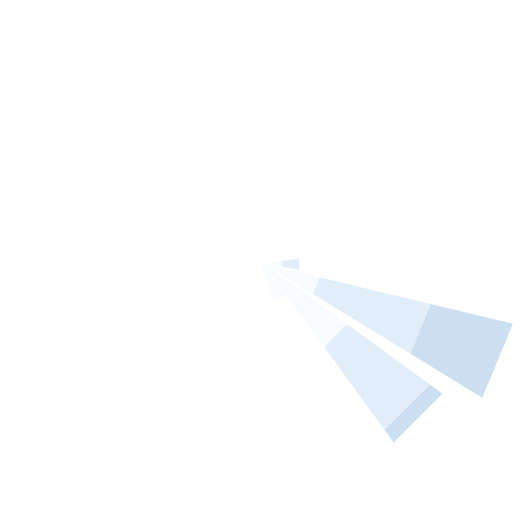

In [109]:
# wind_data
# file_path.is_file()
# windrose.plot_windrose()
# px.data.wind()
# windrose.plot_windrose(average_period, var_name='windspeed', direction_name='winddirection')

# colorPalette = np.array(['#016895', '#4298B5', '#734675', '#FEC51D', '#B6B1A9', '#279989', '#E98300', '#E04F39', 'black'])
# sns.set_palette(sns.color_palette(colorPalette))

ax = WindroseAxes.from_ax()
bins_range = np.arange(1, 6, 1) # 11
ax.bar(average_period['winddirection'], average_period['windspeed'], bins=bins_range, nsector=16, cmap=cm.Blues)
# ax.legend()
ax.grid()
ax.set_yticks([0])
ax.set_xticks([0])
ax.set_xticklabels([''])
ax.set_rgrids([0])
ax.grid(visible=None)
ax.axis('off')
plt.savefig('testing_b.pdf', transparent=True)

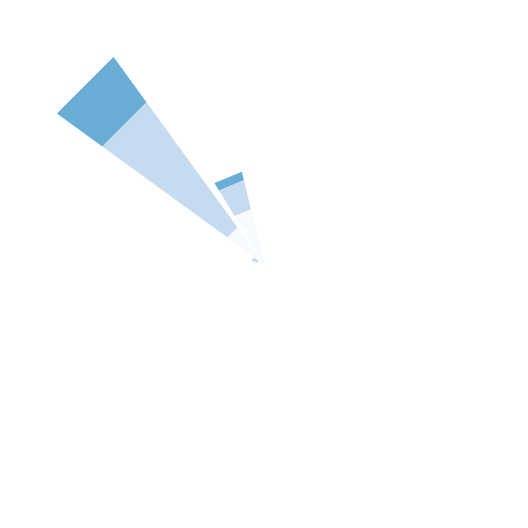

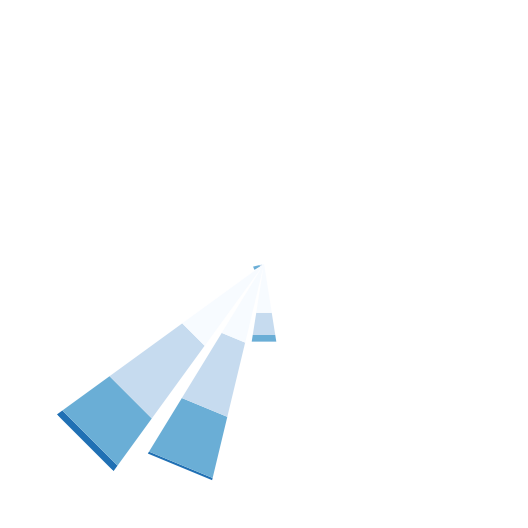

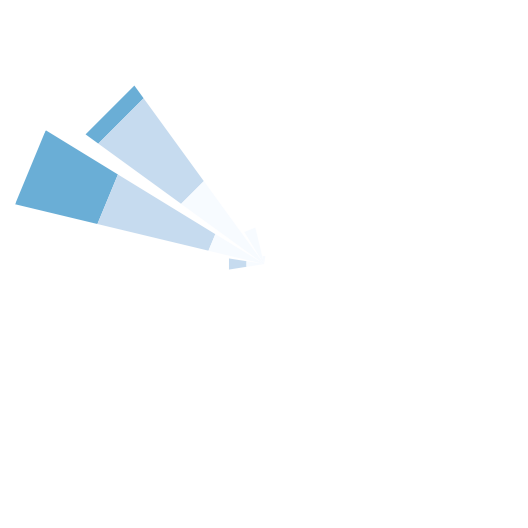

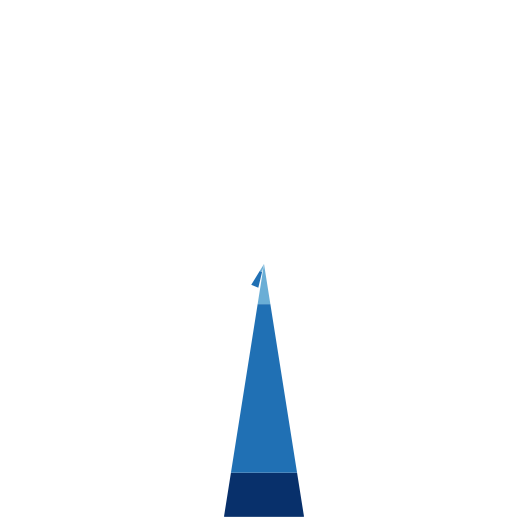

In [25]:
today_date = '180+20230511g'
# ZY1
stop_t = datetime.strptime('10/26/22 18:23', '%m/%d/%y %H:%M')
start_t = stop_t - timedelta(minutes=5)
plot_windrose(start_t, stop_t)
plt.savefig(pathlib.PurePath('05_satellites', '02_figures', 'ZY1_20221026_windrose_' + today_date + '.pdf'), transparent=True)
# GF5
stop_t = datetime.strptime('11/15/22 18:21', '%m/%d/%y %H:%M')
start_t = stop_t - timedelta(minutes=5)
plot_windrose(start_t, stop_t)
plt.savefig(pathlib.PurePath('05_satellites', '02_figures', 'GF5_20221115_windrose_' + today_date + '.pdf'), transparent=True)
# Sentinel-2
stop_t = datetime.strptime('11/18/22 18:25', '%m/%d/%y %H:%M')
start_t = stop_t - timedelta(minutes=5)
plot_windrose(start_t, stop_t)
plt.savefig(pathlib.PurePath('05_satellites', '02_figures', 'Sentinel2_20221118_windrose_' + today_date + '.pdf'), transparent=True)
# EnMAP
stop_t = datetime.strptime('11/16/22 18:40', '%m/%d/%y %H:%M')
start_t = stop_t - timedelta(minutes=5)
plot_windrose(start_t, stop_t)
plt.savefig(pathlib.PurePath('05_satellites', '02_figures', 'EnMAP_20221611_windrose_' + today_date + '.pdf'), transparent=True)

# GHGSat
stop_t = datetime.strptime('11/8/22 20:51', '%m/%d/%y %H:%M')
start_t = stop_t - timedelta(minutes=5)
plot_windrose(start_t, stop_t)
plt.savefig(pathlib.PurePath('05_satellites', '02_figures', 'GHGSat_20221108_windrose_' + today_date + '.pdf'), transparent=True)

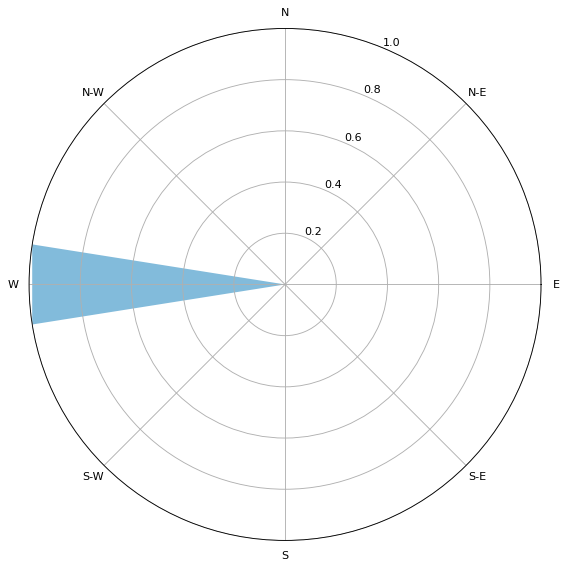

In [157]:
ax = WindroseAxes.from_ax()
bins_range = np.arange(1, 11, 1)
# ax.bar(np.array([90]), np.array([5]), bins=bins_range, nsector=16, cmap=cm.Blues)
ax.bar(np.array([360 - 101]), np.array([5]), bins=bins_range, nsector=16, cmap=cm.Blues)

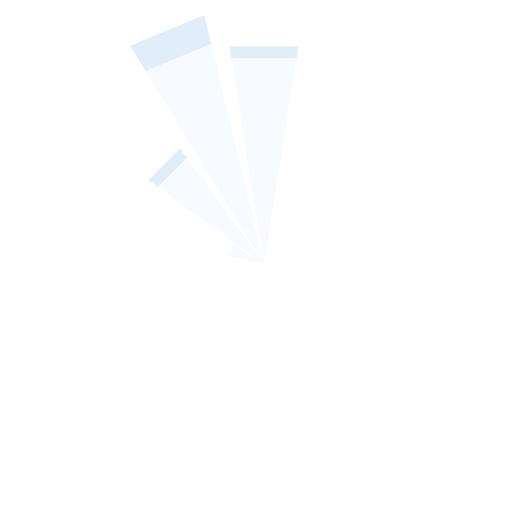

In [31]:
# GHGSat
stop_t = datetime.strptime('11/8/22 20:51', '%m/%d/%y %H:%M')
start_t = stop_t - timedelta(minutes=5)

if start_t.date() != stop_t.date():
    # End function if start and end t are on different dates
    print(
        'Do not attempt to calculate average flow across multiple dates. Please consider a new start or end time.')
    # return
elif start_t.date() > stop_t.date():
    print('Start time is after end time. Time for *you* to do some debugging!')
    # return
else:
    # Load data
    file_name = start_t.strftime('%m_%d')
    # use subclass Path (instead of PurePath) because we need to check if the file exists
    file_path = pathlib.Path('03_wind_data', f'{file_name}.csv')

    # Check if we have a meter file for the input date
    if not file_path.is_file():
        # If file does not exist, we did not conduct releases on that day.
        # Set all values of results_summary to zero or np.nan
        results_summary = {
            'average_windspeed': np.nan,
            'average_winddirection': np.nan,
            'stdev_windspeed': np.nan,
            'stdev_winddirection': np.nan,
        }
    else:
        # If file exists, calculate flow rate summary info:
        # Select data for averaging
        wind_data = pd.read_csv(file_path, parse_dates=['datetime'])
        time_ave_mask = (wind_data['datetime'] >= start_t) & (wind_data['datetime'] <= stop_t)
        average_period = wind_data.loc[time_ave_mask].copy()
        length_before_drop_na = len(average_period)

        # Drop rows with NA values
        average_period.dropna(axis='index', inplace=True, thresh=7)
        length_after_drop_na = len(average_period)
        dropped_rows = length_before_drop_na - length_after_drop_na
        if dropped_rows > 0:
            print(f'Number of rows that were NA in the average period ({start_t} to {stop_t}): {dropped_rows}')

        # Plot wind rose
        # Based on https://python-windrose.github.io/windrose/api.html#windrose.WindroseAxes
        ax = WindroseAxes.from_ax()
        bins_range = np.arange(1, 11, 1)
        ax.bar(450 - average_period['winddirection'], average_period['windspeed'], bins=bins_range, nsector=16, cmap=cm.Blues)
        # ax.legend()
        ax.grid()
        ax.set_yticks([0])
        ax.set_xticks([0])
        ax.set_xticklabels([''])
        ax.set_rgrids([0])
        ax.grid(visible=None)
        ax.axis('off')

In [28]:
radians_to_degrees = 180/np.pi
average_period['winddirection'].mean(),  circmean(average_period['winddirection']/radians_to_degrees)*radians_to_degrees # circmean(average_period['winddirection'])

(126.1647092358804, 126.0122454052838)

In [11]:
average_period.mean()

/Users/evansherwin/PycharmProjects/MethaneDistributions/ven/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


windspeed          2.166400
winddirection    126.164709
day               18.000000
month             11.000000
u_east            -1.139595
u_north            1.749166
dtype: float64

In [30]:
file_path

PosixPath('03_wind_data/11_08.csv')